Index(['Date', 'TikTokViews'], dtype='object')


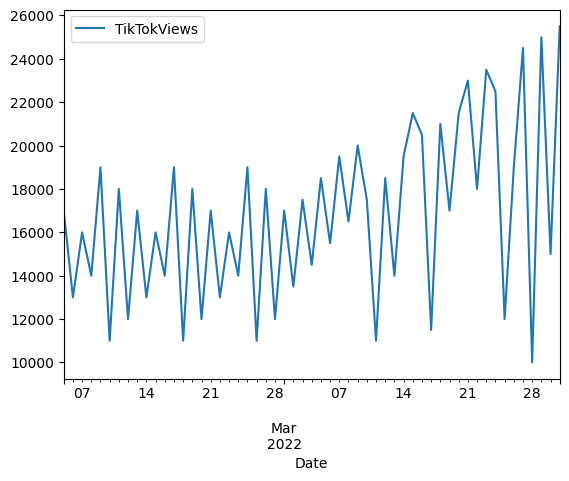

In [22]:
import pandas as pd 
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import pacf, acf

# Corrected file path
data = pd.read_csv('/Users/nicholaschen/machine learning linear regression/tiktokviews.csv')
print(data.columns)  # Print column names to verify
data.set_index(pd.to_datetime(data["Date"]), inplace=True)
data.drop(columns=["Date"], inplace=True)
data.plot(y="TikTokViews")
plt.show()

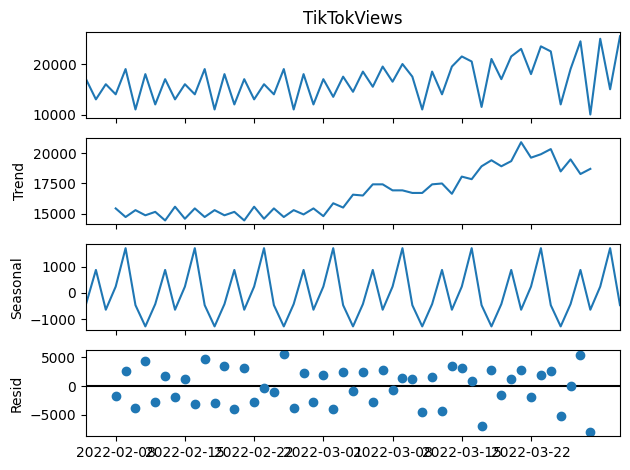

In [26]:
seasonal_decompose(data["TikTokViews"], model="additive").plot()
plt.show()

#### 

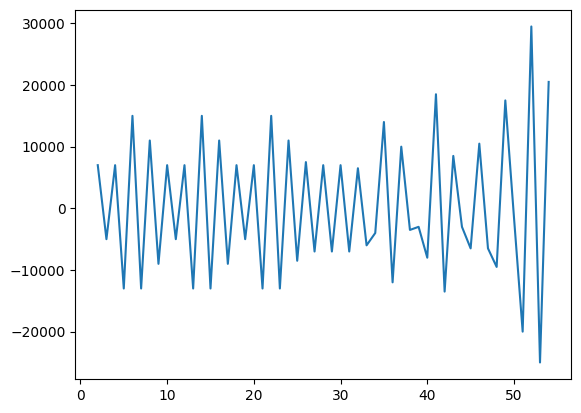

In [27]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    for key, value in result[4].items():
        if result[0] > value:
            return False
    return True

data = pd.read_csv('tiktokViews.csv')
diff_data = data["TikTokViews"]
d = 0

while not check_stationarity(diff_data):
    diff_data = diff_data.diff().dropna()
    d += 1

diff_data.plot()
plt.show()

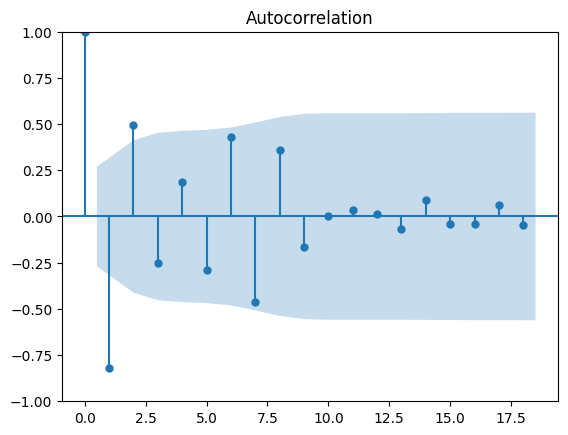

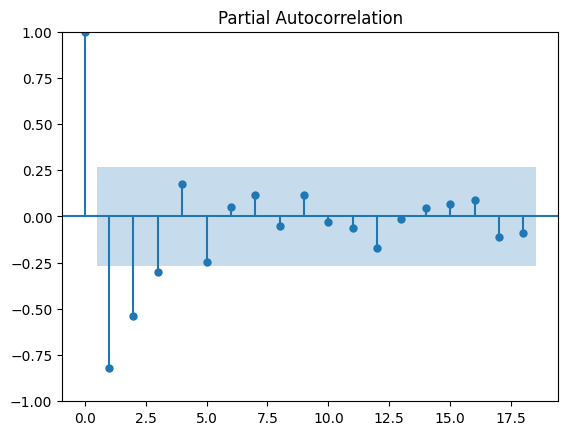

In [28]:
plot_acf(diff_data)
plot_pacf(diff_data)
plt.show()

In [37]:
pacf_values, confint = pacf(diff_data, alpha=0.05, method="ywmle")
confint = confint - pacf_values[:, None]
significant_lags = np.where((pacf_values < confint[:, 0]) | (pacf_values > confint[:,1]))
p = len(significant_lags[-1]) - 1
P = len([x for x in significant_lags_pacf if x != 0 and x <= 12])
print(p, P)
acf_values, confint = acf(diff_data, alpha=0.05)
confint = confint - acf_values[:, None]
significant_lags = np.where((acf_values < confint[:, 0]) | (acf_values > confint[:, 1]))[0]
q = len(significant_lags) - 1
Q = len([x for x in significant_lags_acf if x != 0 and x <= 12])
print(q, Q)

3 3
2 2


In [41]:
D = 0
model = SARIMAX(diff_data, order = (p, d, q), seasonal_order = (P, D, Q, 12))
future = model.fit()
model
print(p, d, q, P, D, Q)

/Users/nicholaschen/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/nicholaschen/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/nicholaschen/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nicholaschen/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few obs

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02036D+01    |proj g|=  8.81884D-01

At iterate    5    f=  9.80694D+00    |proj g|=  7.54180D-02

At iterate   10    f=  9.68421D+00    |proj g|=  2.11006D-01

At iterate   15    f=  9.65945D+00    |proj g|=  1.63830D-02

At iterate   20    f=  9.65845D+00    |proj g|=  5.81755D-03

At iterate   25    f=  9.65685D+00    |proj g|=  2.80563D-03

At iterate   30    f=  9.65548D+00    |proj g|=  6.70550D-03

At iterate   35    f=  9.65361D+00    |proj g|=  5.85804D-03

At iterate   40    f=  9.65350D+00    |proj g|=  2.01666D-04

At iterate   45    f=  9.65348D+00    |proj g|=  1.01761D-03

At iterate   50    f=  9.65348D+00    |proj g|=  2.75075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nicholaschen/Library/Python/3.12/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/nicholaschen/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicholaschen/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


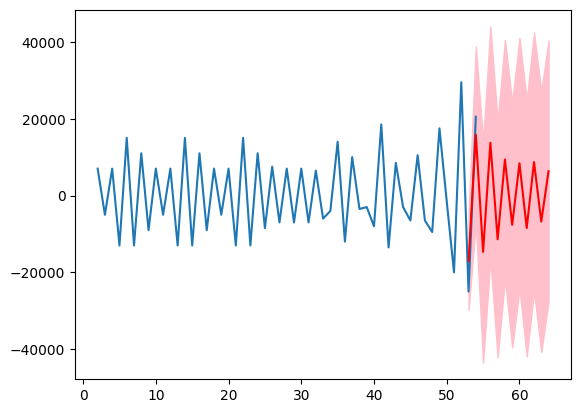

In [42]:
forecast_periods = 12
forecast = future.get_forecast(steps = forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
plt.plot(diff_data, label = "Observed")
plt.plot(forecast_mean, label="Forecast", color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:,1], color="pink")
plt.show()

54


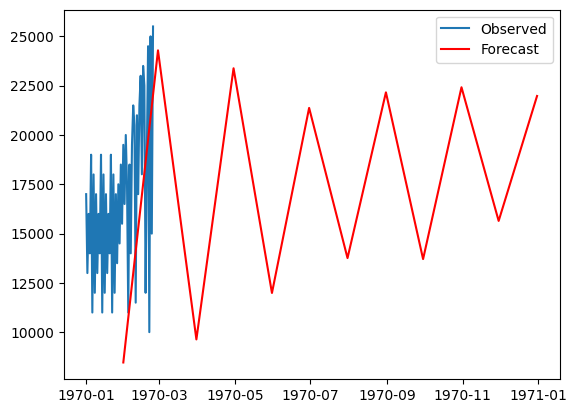

In [48]:
last = data["TikTokViews"].iloc[-1]
forecast_og = []
for i in forecast_mean:
    forecast_og.append(last + i)
    last += i

start_date = data.index[-1]
print(start_date)

date_range = pd.date_range(start=start_date, periods=len(forecast_og), freq="ME")
forecast_og_df = pd.DataFrame(forecast_og, index=date_range, columns=["TikTokViews"])

plt.plot(data["TikTokViews"], label="Observed")
plt.plot(forecast_og_df, label="Forecast", color="red")
plt.legend()
plt.show()

In [49]:
observed = diff_data[-forecast_periods:]

mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 14939.027401154954
MSE: 274185965.8119963
